In [8]:
# Cài đặt thư viện (Bỏ comment dòng dưới nếu bạn chưa cài)
# !pip install transformers datasets evaluate rouge_score matplotlib nltk pandas torch

import torch
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import evaluate
from tqdm.auto import tqdm
import re

# --- CẤU HÌNH ---
# Đường dẫn model Phase 2 của bạn (Sửa lại nếu cần)
MODEL_PATH = r"D:\do-an-tot-nghiep\models\final_vit5_model_phase2"

# Dataset dùng để kiểm tra chéo (VietNews)
CROSS_DATASET_NAME = "ThanhChinhBK/vietnews" 
# Nếu mạng lỗi, thử thay bằng: "nam194/vietnews"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🖥️ Thiết bị sử dụng: {DEVICE}")

# Tải bộ tách câu NLTK (Bắt buộc cho ROUGE chuẩn)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    nltk.download('punkt_tab')

🖥️ Thiết bị sử dụng: cuda


In [9]:
print(f"📦 Đang tải dataset kiểm tra chéo: {CROSS_DATASET_NAME}...")
try:
    # VietNews thường có sẵn split 'test'
    dataset = load_dataset(CROSS_DATASET_NAME, split="test")
except Exception as e:
    print(f"⚠️ Lỗi tải {CROSS_DATASET_NAME}: {e}")
    print("👉 Đang thử tải 'nam194/vietnews' thay thế...")
    dataset = load_dataset("nam194/vietnews", split="test")

# Chuyển sang DataFrame
df_test = dataset.to_pandas()

# Đổi tên cột về chuẩn (input_text, target_text)
# VietNews gốc thường dùng: 'article' (bài báo) và 'abstract' (tóm tắt)
rename_map = {
    "article": "input_text", 
    "abstract": "target_text",
    "document": "input_text",
    "summary": "target_text"
}
df_test = df_test.rename(columns={k: v for k, v in rename_map.items() if k in df_test.columns})

# Lọc bỏ mẫu lỗi (nếu có)
df_test = df_test.dropna(subset=['input_text', 'target_text'])

# Lấy mẫu ngẫu nhiên 200 bài để test nhanh (Muốn chạy hết thì bỏ dòng này)
TEST_SAMPLES = 200
if len(df_test) > TEST_SAMPLES:
    df_eval = df_test.sample(n=TEST_SAMPLES, random_state=42)
else:
    df_eval = df_test

print(f"✅ Đã chuẩn bị {len(df_eval)} mẫu VietNews để đánh giá.")
print("-" * 50)
print(f"📝 Ví dụ dữ liệu gốc:\n{df_eval.iloc[0]['input_text'][:150]}...")
print(f"📝 Ví dụ tóm tắt mẫu:\n{df_eval.iloc[0]['target_text'][:150]}...")

📦 Đang tải dataset kiểm tra chéo: ThanhChinhBK/vietnews...
⚠️ Lỗi tải ThanhChinhBK/vietnews: Dataset 'ThanhChinhBK/vietnews' doesn't exist on the Hub or cannot be accessed.
👉 Đang thử tải 'nam194/vietnews' thay thế...


c:\Users\kyen\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kyen\.cache\huggingface\hub\datasets--nam194--vietnews. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating test split: 100%|██████████| 22498/22498 [00:00<00:00, 192690.55 examples/s]


✅ Đã chuẩn bị 200 mẫu VietNews để đánh giá.
--------------------------------------------------
📝 Ví dụ dữ liệu gốc:
Trong ngày 8-9/7 , các thí_sinh đăng_ký tuyển_sinh vào Học_viện Báo_chí & Tuyên_truyền ( AJC ) sẽ tham_gia bài thi năng_khiếu Báo_chí . Đây là năm thứ...
📝 Ví dụ tóm tắt mẫu:
Đề thi năng_khiếu Báo_chí của học_viện Báo_chí & Tuyên_truyền năm 2019 thử_thách sinh_viên với các kiến_thức xã_hội_đại_chúng bên cạnh đó lồng_ghép cá...


In [10]:
print(f"⏳ Đang load model của BẠN từ: {MODEL_PATH}")
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
    model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_PATH).to(DEVICE)
    print("✅ Load model thành công!")
except Exception as e:
    print(f"❌ Lỗi load model: {e}")
    print("👉 Hãy kiểm tra kỹ đường dẫn thư mục model.")

⏳ Đang load model của BẠN từ: D:\do-an-tot-nghiep\models\final_vit5_model_phase2
✅ Load model thành công!


In [11]:
preds = []
refs = []

print(f"🚀 Bắt đầu sinh tóm tắt cho {len(df_eval)} bài báo...")

# Vòng lặp sinh tóm tắt
for index, row in tqdm(df_eval.iterrows(), total=len(df_eval)):
    input_text = str(row['input_text'])
    target_text = str(row['target_text'])
    
    # Tokenize (Cắt ngắn nếu dài quá 1024 token)
    inputs = tokenizer(input_text, return_tensors="pt", max_length=1024, truncation=True).to(DEVICE)
    
    # Generate (Sinh văn bản)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=128,        # Độ dài tóm tắt tối đa
            num_beams=4,               # Beam search giúp câu văn mượt hơn
            repetition_penalty=2.5,    # Phạt lặp từ
            no_repeat_ngram_size=3,    # Cấm lặp cụm 3 từ
            length_penalty=1.0,
            early_stopping=True
        )
    
    # Decode ra văn bản
    pred_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Tách câu chuẩn bằng NLTK (Bước quan trọng để tính ROUGE đúng)
    pred_sent = "\n".join(nltk.sent_tokenize(pred_text.strip()))
    ref_sent = "\n".join(nltk.sent_tokenize(target_text.strip()))
    
    preds.append(pred_sent)
    refs.append(ref_sent)

print("✅ Hoàn tất sinh văn bản.")

🚀 Bắt đầu sinh tóm tắt cho 200 bài báo...


100%|██████████| 200/200 [19:00<00:00,  5.70s/it]

✅ Hoàn tất sinh văn bản.


In [12]:
print("📊 Đang tính toán điểm số...")
rouge = evaluate.load("rouge")
scores = rouge.compute(predictions=preds, references=refs, use_stemmer=True)

# Làm tròn số
final_scores = {k: round(v * 100, 2) for k, v in scores.items()}

print("\n" + "="*40)
print(" KẾT QUẢ ROUGE")
print("="*40)
print(final_scores)

📊 Đang tính toán điểm số...

 KẾT QUẢ ROUGE
{'rouge1': np.float64(45.6), 'rouge2': np.float64(22.16), 'rougeL': np.float64(27.88), 'rougeLsum': np.float64(34.59)}


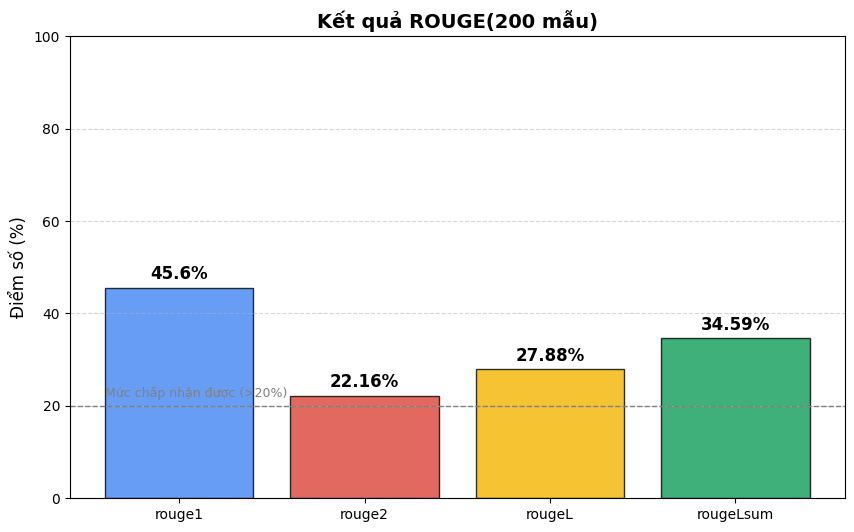

In [14]:
# Dữ liệu vẽ biểu đồ
metrics = list(final_scores.keys())
values = list(final_scores.values())
colors = ['#4285F4', '#DB4437', '#F4B400', '#0F9D58']

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=colors, edgecolor='black', alpha=0.8)

plt.ylim(0, 100)
plt.ylabel('Điểm số (%)', fontsize=12)
plt.title(f'Kết quả ROUGE({len(df_eval)} mẫu)', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Hiển thị số liệu
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height}%', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Đường tham chiếu mức đạt yêu cầu
plt.axhline(y=20, color='gray', linestyle='--', linewidth=1)
plt.text(-0.4, 22, 'Mức chấp nhận được (>20%)', color='gray', fontsize=9)

plt.show()

In [15]:
print("--- SO SÁNH TÓM TẮT THỰC TẾ  ---\n")
for i in range(3): # Xem 3 mẫu đầu
    print(f"📝 Bài số {i+1}:")
    print(f"Gốc (Rút gọn): {df_eval.iloc[i]['input_text'][:200]}...")
    print(f"AI Tóm tắt:    {preds[i].replace(chr(10), ' ')}")
    print(f"Người viết:    {refs[i].replace(chr(10), ' ')}")
    print("-" * 80)

--- SO SÁNH TÓM TẮT THỰC TẾ  ---

📝 Bài số 1:
Gốc (Rút gọn): Trong ngày 8-9/7 , các thí_sinh đăng_ký tuyển_sinh vào Học_viện Báo_chí & Tuyên_truyền ( AJC ) sẽ tham_gia bài thi năng_khiếu Báo_chí . Đây là năm thứ 5 liên_tiếp , AJC sử_dụng hình_thức thi năng_khiế...
AI Tóm tắt:    Trong ngày 8-9/7, các thí sinh đăng ký vào Học viện Báo chí & Tuyên truyền (JC) sẽ tham gia thi năng_khiếu Báo_chí 2019. Đề thi bao gồm các môn Ngữ văn, Lịch sử, Địa lý và Giáo dục công dân. Các thí sinh sẽ làm bài thi trắc nghiệm 30 câu trong thời gian 30 phút với nội dung đề cập đến vụ việc tài xế taxi Vinasun bỏ mặc nạn nhân để liên hệ với lối sống của người Việt Nam. Đặc biệt, phần trắc nghiệm có tính mở và bày tỏ quan điểm của bản thân về vấn đề thời
Người viết:    Đề thi năng_khiếu Báo_chí của học_viện Báo_chí & Tuyên_truyền năm 2019 thử_thách sinh_viên với các kiến_thức xã_hội_đại_chúng bên cạnh đó lồng_ghép các sự_kiện nóng , nhân_vật có ảnh_hưởng như lối sống của người Việt , ...
----------------------